In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

In [2]:
# ----------------------- Data loading and preprocessig ---------------------- #

file_train = 'ZipDigits.train'
file_test = 'ZipDigits.test'


def read_data(file_name):
    digits = []
    images = []
    with open(file_name, 'r') as f:
        for line in f:
            line = line.strip().split(' ')
            line = [float(i) for i in line]
            digit = int(line[0])
            data = line[1:]
            images.append(data)
            digits.append(digit)
    return np.array(images), np.array(digits)


def get_features(file_name):
    images, digits = read_data(file_name)
    images = images.reshape(-1, 16, 16)
    images = (images + 1) / 2  # normalize between [0,1]

    index = (digits == 1) | (digits == 5)
    images = images[index]
    digits = digits[index]

    # Extract feature
    intensities = images.reshape(-1, 16 * 16).mean(axis=-1)
    symmetry = np.power(images[..., ::-1] - images,
                        2).reshape(images.shape[0], -1).mean(axis=-1)

    ind_1 = (digits == 1)
    ind_5 = (digits == 5)
    labels = np.zeros(digits.shape[0])
    labels[ind_1] = 1
    labels[ind_5] = -1
    features = np.concatenate((intensities[:, None], symmetry[:, None]), axis=1)
    return features, labels

# ------------------------------ train features ------------------------------ #
features_train, labels_train = get_features(file_train)

# ------------------------------- test features ------------------------------ #
features_test, labels_test = get_features(file_test)


In [7]:
print(len(features_train))
print(len(features_test))

1561
424


E_in: 0.07814635459261186
E_out: 0.15943583882828666


Text(0.5, 1.0, 'Test data')

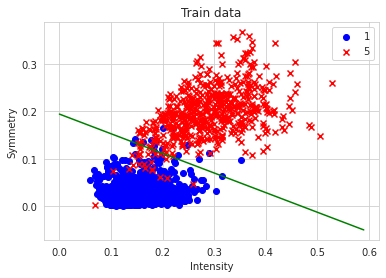

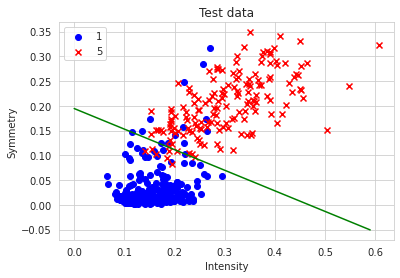

In [3]:
# apply gradient descent on the logistic regression
features_train_aug = np.concatenate((np.ones((features_train.shape[0], 1)), features_train), axis=1)
features_test_aug = np.concatenate((np.ones((features_test.shape[0], 1)), features_test), axis=1)

w = np.zeros(3)
max_iter = 1000
eta = 10

list_Ein = []
list_Eout = []

E_in = np.mean(np.log(1+np.exp(-labels_train * np.dot(features_train_aug, w))))
E_out = np.mean(np.log(1+np.exp(-labels_test * np.dot(features_test_aug, w))))

list_Ein.append(E_in)
list_Eout.append(E_out)

for i in range(max_iter):
    # compute the gradient

    grad = np.mean(
        -labels_train[:, None] * features_train_aug /
        (1 + np.exp(labels_train * np.dot(features_train_aug, w)))[:, None],
        axis=0)
    w = w - eta * grad

    E_in = np.mean(np.log(1+np.exp(-labels_train * np.dot(features_train_aug, w))))
    E_out = np.mean(np.log(1+np.exp(-labels_test * np.dot(features_test_aug, w))))

    list_Ein.append(E_in)
    list_Eout.append(E_out)

w_first = w

# plt.plot(list_Ein, label='Ein')
# plt.plot(list_Eout, label='Eout')
# plt.legend()

print(f'E_in: {E_in}')
print(f'E_out: {E_out}')


# plot decision boundary

x_lin = np.arange(0, 0.6, 0.01)
y_lin = -(w[0] + w[1] * x_lin) / w[2]

# ------------------------------ train features ------------------------------ #

plt.figure(1)
plt.scatter(features_train[:, 0][labels_train == 1],
            features_train[:, 1][labels_train == 1],
            c='b',
            marker='o',
            label='1')
plt.scatter(features_train[:, 0][labels_train == -1],
            features_train[:, 1][labels_train == -1],
            c='r',
            marker='x',
            label='5')
plt.legend()

plt.plot(x_lin, y_lin, c='g', label='Decision boundary')

plt.xlabel('Intensity')
plt.ylabel('Symmetry')
plt.title('Train data')


# ------------------------------- test features ------------------------------ #
features_test, labels_test = get_features(file_test)

plt.figure(2)
plt.scatter(features_test[:, 0][labels_test == 1],
            features_test[:, 1][labels_test == 1],
            c='b',
            marker='o',
            label='1')
plt.scatter(features_test[:, 0][labels_test == -1],
            features_test[:, 1][labels_test == -1],
            c='r',
            marker='x',
            label='5')
plt.legend()
plt.plot(x_lin, y_lin, c='g', label='Decision boundary')

plt.xlabel('Intensity')
plt.ylabel('Symmetry')
plt.title('Test data')



In [15]:
# apply gradient descent on the logistic regression for 3rd order polynomial transform

# (x1, x2) -> (1, x1, x2, x1^2, x2^2, x1 x2, x1^3, x2^3, x1^2 x2, x1 x2^2)

def convert_to_polynomial(features):
    x1 = features[:, [0]]
    x2 = features[:, [1]]
    out = np.concatenate((x1, x2, x1**2, x2**2, x1 * x2, x1**3, x2**3, x1**2 * x2,
                   x1 * x2**2), axis=1)
    return out



features_train_aug = np.concatenate((np.ones((features_train.shape[0], 1)), convert_to_polynomial(features_train)), axis=1)
features_test_aug = np.concatenate((np.ones((features_test.shape[0], 1)), convert_to_polynomial(features_test)), axis=1)

w = np.zeros(features_test_aug.shape[-1])
max_iter = 1000
eta = 10

list_Ein = []
list_Eout = []

E_in = np.mean(np.log(1+np.exp(-labels_train * np.dot(features_train_aug, w))))
E_out = np.mean(np.log(1+np.exp(-labels_test * np.dot(features_test_aug, w))))

list_Ein.append(E_in)
list_Eout.append(E_out)

for i in range(max_iter):
    # compute the gradient

    grad = np.mean(
        -labels_train[:, None] * features_train_aug /
        (1 + np.exp(labels_train * np.dot(features_train_aug, w)))[:, None],
        axis=0)
    w = w - eta * grad

    E_in = np.mean(np.log(1+np.exp(-labels_train * np.dot(features_train_aug, w))))
    E_out = np.mean(np.log(1+np.exp(-labels_test * np.dot(features_test_aug, w))))

    list_Ein.append(E_in)
    list_Eout.append(E_out)

print(f'E_in: {E_in}')
print(f'E_out: {E_out}')




E_in: 0.07744898622824323
E_out: 0.16285430372087684


/home/ash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: The following kwargs were not used by contour: 'label'
/home/ash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: The following kwargs were not used by contour: 'label'


Text(0.5, 1.0, 'Test data')

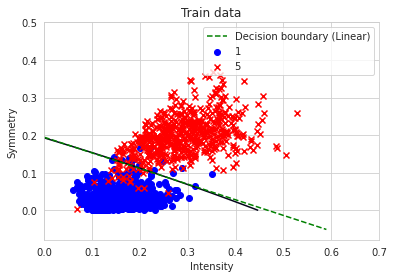

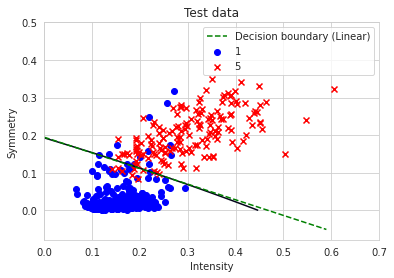

In [37]:
def calc_f(x1, x2, w):
    components = (1, x1, x2, x1**2, x2**2, x1 * x2, x1**3, x2**3, x1**2 * x2,
                   x1 * x2**2)
    res = 0
    for i, elem in enumerate(components):
        res += elem * w[i]
    return res

x = np.linspace(0, 0.7, 100)
y = np.linspace(0, 0.5, 100)

X, Y = np.meshgrid(x, y)
Z = calc_f(X, Y, w)



# ------------------------------ train features ------------------------------ #

plt.figure(1)
plt.scatter(features_train[:, 0][labels_train == 1],
            features_train[:, 1][labels_train == 1],
            c='b',
            marker='o',
            label='1')
plt.scatter(features_train[:, 0][labels_train == -1],
            features_train[:, 1][labels_train == -1],
            c='r',
            marker='x',
            label='5')

plt.plot(x_lin, y_lin, c='g', linestyle='--', label='Decision boundary (Linear)')
plt.contour(X, Y, Z, levels=[0], label='Decision boundary (3rd order)')

plt.legend()

plt.xlabel('Intensity')
plt.ylabel('Symmetry')
plt.title('Train data')

# ------------------------------- test features ------------------------------ #
features_test, labels_test = get_features(file_test)

plt.figure(2)
plt.scatter(features_test[:, 0][labels_test == 1],
            features_test[:, 1][labels_test == 1],
            c='b',
            marker='o',
            label='1')
plt.scatter(features_test[:, 0][labels_test == -1],
            features_test[:, 1][labels_test == -1],
            c='r',
            marker='x',
            label='5')

plt.plot(x_lin,
         y_lin,
         c='g',
         linestyle='--',
         label='Decision boundary (Linear)')
plt.contour(X, Y, Z, levels=[0], label='Decision boundary (3rd order)')
plt.legend()
plt.xlabel('Intensity')
plt.ylabel('Symmetry')
plt.title('Test data')

(40, 50)

In [13]:
print(np.sqrt(8/1561 * np.log( 4*(3121**3+1) / 0.05 )) + 0.0781)
print(np.sqrt(8 / 848 * np.log(2 / 0.05)) + 0.1594)


0.46041067163059257
0.34594959010170084


In [12]:
print(np.sqrt(8 / 1561 * np.log(4 * (3121**10 + 1) / 0.05)) + 0.07745)
print(np.sqrt(8 / 848 * np.log(2 / 0.05)) + 0.1628)


0.7368466300587968
0.34934959010170086
